# Accelerated Diffusion calculations with Numba 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import jit, njit, prange
import matplotlib.animation as animation

#### Implementing the diffusion iteration

A discrete diffusion iteration relation can be implemented on a distribution, $u_{n}(i,j)$, of function values on a grid. It can be thought of as a function that replaces each value in the grid with the average value of its neighbouring grid points. We also use the condition that the boundary values (points around the edge of the grid) remain constant.

Here we consder $u(i,j)$ to be a two dimensional numpy array of data type 'float64' of length $N$. The following logic is considered:
1. Construct a new array, of equal shape and data type, representing the next iteration, $u_{n+1}(i,j)$. We intend to fill this array with values of the next iteration step. Hence, we use np.empty_like() to reduce overhead of filling the array with unessacary values that will be overwritten later: we instead save the addresses of memory it reserves for the array. This improves speed (but leaves behind whatever values were previously occupying that space in memory).
2. We form a nested 'for' loop to iterate over each array element in $u_{n}(i,j)$. The outer loop iterates over the $i^{th}$ row and the inner loop iterates over the $j^{th}$ column.
3. We use an 'if' statement within the nested loop to first satisfy the bountry conditions: we initially fill the 'edge' rows and columns (i.e. when $i,j = 0$ and $i,j = N-1$ since python uses zero based indexing) of the 'empty' array, $u_{n+1}(i,j)$ with the same values as the starting array $u_{n}(i,j)$. 
4. We then fill in the rest of the array using the diffusion iteration relation. We use an 'else' statement to avoid overwriting any previously filled elements. At each point, the average value of its neighbouring grid points is appended to $u_{n+1}(i,j)$. 
5. Return the now filled array $u_{n+1}(i,j)$.


#### Without Numba acceleration: using NumPy

In [2]:
def diffusion_iteration(u_n):
    """
    Perform one diffusion step for all given grid points.

    Parameters
    ----------
    u_n : numpy.ndarray
          Numpy array of type float64 and dimension (N + 1, N + 1) that stores the
          function values at step n.

    This function returns a Numpy array of dimension (N + 1, N + 1) of type float64
    that contains the function values after performing one step of the above diffusion
    iteration.
    """ 
    u_n_1 = np.empty_like(u_n)      # empty array of equal shape and data type for the n+1th iterate
    
    N_x, N_y = np.shape(u_n)        # dimensionality length of array to loop over

    for i in range(N_x):            # loop over rows
        for j in range(N_y):        # loop over columns
            
            # boundry conditions require edge rows and columns to stay constant
            if i == 0 or j == 0 or i == N_x-1 or j == N_y-1:
                u_n_1[i,j] = u_n[i,j]
            
            # diffusion relation takes average of neighbouring points
            else:
                u_n_1[i,j] =  0.25 * (u_n[i+1,j] + u_n[i-1,j] + u_n[i,j+1] + u_n[i,j-1])

    return u_n_1

We can benchmark the execution time of the function as a function of growing dimension size, $N$, using the _%timeit_ ipython magic function. We expect the runtime complexity of the algorithm to be of order $\mathcal{O}(N_x N_y) = \mathcal{O}(N^2)$ since our nested loop is transversing along two dimensions.

In [3]:
time = []    # time taken to execute function - to plot
stdev = []   # standard deviation of running time over multiple loops
N = 1000
step = 100    

# find function running time for all specified N values in given range
for N in range(1,N+1,step):
    array = np.random.rand(N,N)
    t = %timeit -o -n 3 diffusion_iteration(array)
    time.append(t.average)
    stdev.append(t.stdev)

7.22 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
11.6 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
46.1 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
107 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
187 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
293 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
431 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
586 ms ± 6.23 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
771 ms ± 7.98 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
992 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


Text(0, 0.5, 'Time (ms)')

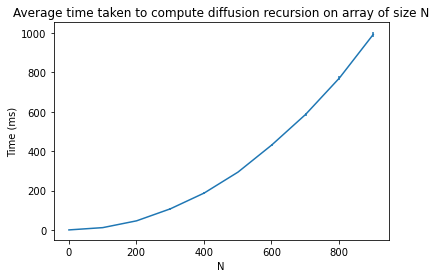

In [4]:
# plot running time against array size N
# error bar represents standard deviation from given repeats
plt.errorbar(np.arange(1,N+1,step), [i*1e3 for i in time], [i*1e3 for i in stdev])
plt.title('Average time taken to compute diffusion recursion on array of size N')
plt.xlabel('N')
plt.ylabel('Time (ms)')

The graph displays the $\mathcal{O}(N^2)$ running time. We can see that increasing from $N = 400$ to $N = 800$ roughly increases the runtime from ~$200 ms$ to ~$800 ms$ in accordance to doubling resulting to factor of $2^2 = 4$   increase. (Ryzen 5 CPU)

#### With Numba acceleration: using just-in-time compilation

We introduce the _@njit_ decorator to allow for just-in-time compilation.

In [5]:
@njit
def diffusion_iteration_numba(u_n):
    """
    Perform one diffusion step for all given grid points.

    Parameters
    ----------
    u_n : numpy.ndarray
          Numpy array of type float64 and dimension (N + 1, N + 1) that stores the
          function values at step n.

    This function returns a Numpy array of dimension (N + 1, N + 1) of type float64
    that contains the function values after performing one step of the above diffusion
    iteration.
    """ 
    u_n_1 = np.empty_like(u_n)      # empty array of equal shape and data type for the n+1th iterate
    
    N_x, N_y = np.shape(u_n)        # dimensionality length of array to loop over

    for i in range(N_x):            # loop over rows
        for j in range(N_y):        # loop over columns
            
            # boundry conditions require edge rows and columns to stay constant
            if i == 0 or j == 0 or i == N_x-1 or j == N_y-1:
                u_n_1[i,j] = u_n[i,j]
            
            # diffusion relation takes average of neighbouring points
            else:
                u_n_1[i,j] =  0.25 * (u_n[i+1,j] + u_n[i-1,j] + u_n[i,j+1] + u_n[i,j-1])

    return u_n_1

In [9]:
time_numba = []      # time taken to execute function - to plot
stdev_numba = []     # standard deviation of running time over multiple loops

# find function running time for all specified N values in given range
for N in range(1,N+1,step):
    array = np.random.rand(N,N)
    t = %timeit -o -n 100 diffusion_iteration_numba(array)
    time_numba.append(t.average)
    stdev_numba.append(t.stdev)

923 ns ± 29.8 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
14 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
41.3 µs ± 7.87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
71.2 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
126 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
232 µs ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
293 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
421 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
551 µs ± 40.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
787 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0, 0.5, 'Time (μs)')

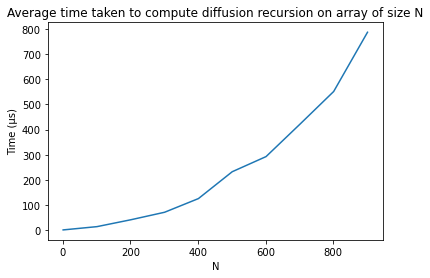

In [10]:
# plot running time against array size N
# error bar represents standard deviation from given repeats
plt.errorbar(np.arange(1,N+1,step), [i*1e6 for i in time_numba], [i*1e3 for i in stdev_numba])
plt.title('Average time taken to compute diffusion recursion on array of size N')
plt.xlabel('N')
plt.ylabel('Time (μs)')

Similarly, the Numba njit accelerated algorithm executes the function on $\mathcal{O}(N^2)$ runtime. We can see that at $N = 400$ the runtime is ~ $120 ms$ and at $N = 800$ the runtime is ~ $500 ms$ (~x4 faster). (Ryzen 5 CPU)

We observe that the Numba njit compiler performs a on an order of a magnitude quicker than the pure python code (see figure below). Therefore, the efficiency of running object code overcomes the inefficiency of recompiling the function every time it runs.

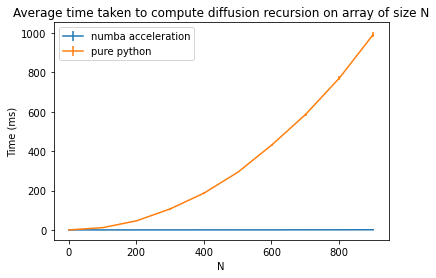

In [11]:
plt.errorbar(np.arange(1,N+1,step), [i*1e3 for i in time_numba], [i*1e3 for i in stdev_numba], label = 'numba acceleration')
plt.errorbar(np.arange(1,N+1,step), [i*1e3 for i in time], [i*1e3 for i in stdev], label = 'pure python' )
plt.title('Average time taken to compute diffusion recursion on array of size N')
plt.xlabel('N')
plt.ylabel('Time (ms)')
plt.legend()

#### With Numba acceleration: parallelizing

We can parallelize the outer loop by introducing Numba’s _prange()_ instead of _range()_ to specify that a loop can be parallelized. We can do this since the loop does not have cross iteration dependencies. The function will then execute across the different cores of the CPU.

In [12]:
@njit(parallel=True)
def diffusion_iteration_parallel(u_n):
    """
    Perform one diffusion step for all given grid points.

    Parameters
    ----------
    u_n : numpy.ndarray
          Numpy array of type float64 and dimension (N + 1, N + 1) that stores the
          function values at step n.

    This function returns a Numpy array of dimension (N + 1, N + 1) of type float64
    that contains the function values after performing one step of the above diffusion
    iteration.
    """ 
    u_n_1 = np.empty_like(u_n)      # empty array of equal shape and data type for the n+1th iterate
    
    N_x, N_y = np.shape(u_n)        # dimensionality length of array to loop over

    for i in prange(N_x):           # loop over rows
        for j in range(N_y):        # loop over columns
            
            # boundry conditions require edge rows and columns to stay constant
            if i == 0 or j == 0 or i == N_x-1 or j == N_y-1:
                u_n_1[i,j] = u_n[i,j]
            
            # diffusion relation takes average of neighbouring points
            else:
                u_n_1[i,j] =  0.25 * (u_n[i+1,j] + u_n[i-1,j] + u_n[i,j+1] + u_n[i,j-1])

    return u_n_1

In [16]:
time_parallel = []      # time taken to execute function - to plot
stdev_parallel = []     # standard deviation of running time over multiple

for N in range(1,N+1,step):
    array = np.random.rand(N,N)
    t = %timeit -o -n 100 diffusion_iteration_parallel(array)
    time_parallel.append(t.average)
    stdev_parallel.append(t.stdev)

33.4 µs ± 4.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
44.8 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
51.1 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
55.1 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
76.8 µs ± 8.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
101 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
122 µs ± 7.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
164 µs ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
222 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
277 µs ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


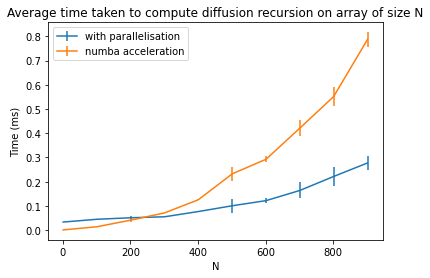

In [17]:
# plot running time against array size N
# error bar represents standard deviation from given repeats
plt.errorbar(np.arange(1,N+1,step), [i*1e3 for i in time_parallel], [i*1e3 for i in stdev_numba], label = 'with parallelisation')
plt.errorbar(np.arange(1,N+1,step), [i*1e3 for i in time_numba], [i*1e3 for i in stdev_numba], label = 'numba acceleration' )
plt.title('Average time taken to compute diffusion recursion on array of size N')
plt.xlabel('N')
plt.ylabel('Time (ms)')
plt.legend()

We notice that for $N < 180$ there is an overhead converting the source  python code to machine code: the speedup gained from compilation does not outweigh the overhead of compiling that code. However for $N > 180$, a speedup is observed. The Ryzen 5 CPU has a 6 cores, so a theoretical speedup of $6$x is expected. However, for $N < 1000$, as plotted above, the greatest speedup is just shy of $4$x. We would expect the speedup to get closer to the theoretical value for larger $N$ at which point the overhead would become neglegible.

#### Animating Diffusion

We can now construct an animation with the following logic:
1. Initialize a starting array, $u_0(i,j)$, to diffuse. Append to an empty (tensor) array, which will contain all the 'frames'.
2. Feed $u_0(i,j)$ into the diffusion function to calculate the next iteration in the diffusion, $u_1(i,j)$. Append $u_1(i,j)$ to the 'frames' array.
3. Feed the previous array, $u_1(i,j)$, into the diffusion function to calculate the $n + 1 th$ iteration, $u_2(i,j)$. Append to 'frames' array.
4. Repeat for $n = 2, 3, 4 ..., T$.

Note that this will construct a three-dimensional array, along which the 'frames' of the animation are contained. Plotting each 'slice' ([2] index) chronologically will produce an animation.

To control the speed of the animation, we choose to parametrize $T = fps * nSeconds$, where $fps$ is the frames per second of our animation, and $nSeconds$ is the total length of our animation.

The example starting array used is a 'circle', where all values in the array are zero except those that define a circle in the centre of the array. The radius of the circle can be controlled by changing the parameters of the simple circle equation below.

<IPython.core.display.Javascript object>


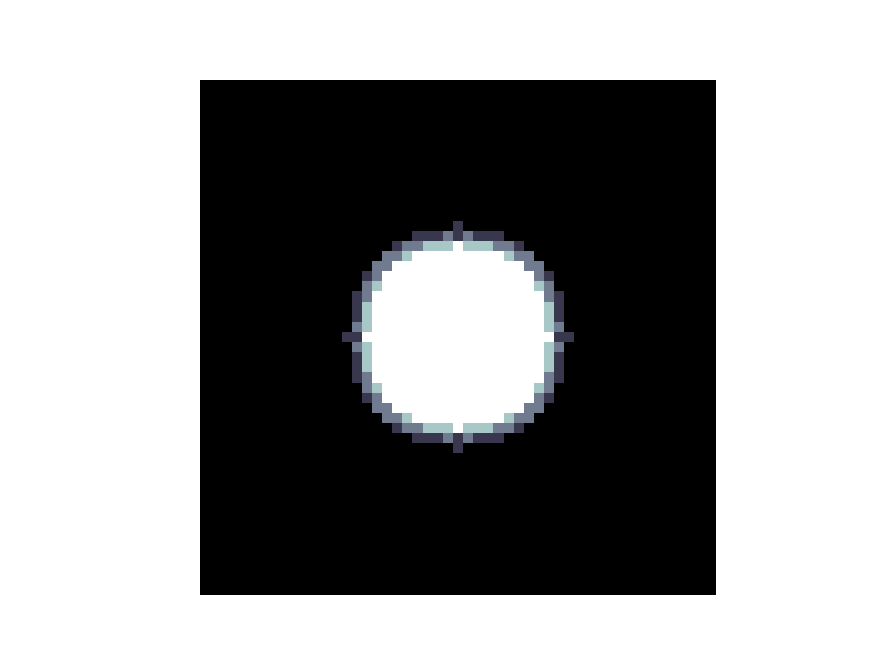

In [18]:
%matplotlib notebook

# define parameters of a circle in the grid
grid_size = 50    # our dimension size 'N' 
radius = 10      

# create array with zeros and a circle (values = 1) in the centre
y,x = np.ogrid[-(grid_size/2) : (grid_size/2)+1, -(grid_size/2): (grid_size/2)+1]
circle = x**2+y**2 <= radius**2
circle = circle.astype(float)

# set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
plt.axis('off')

# define the parameters of the animation
fps = 60
nSeconds = 5

# loop and append the output for each 'frame' to an empty array
frames = []     # array to contain all frames of animation
u_n = circle    # initialize starting array 
for i in range(fps*nSeconds):
    u_n = diffusion_iteration_parallel(u_n)
    frames.append(u_n)

# plot inital array
im = plt.imshow(circle, cmap='bone')

# animate figure using the matplotlib animation.FuncAnimation class
def animate_func(i):
    im.set_array(frames[i])
    return [im]
anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds*fps, interval = 1000/fps)


#### Specifying a set of indicies for which values stay constant

We now introduce a set, $S$, of two dimensional indicies specifying the location for which values in the array stay constant. Here we consider $S$ to be a two dimensional numpy array where each row corresponds to the 'constant indicies'. There are two columns, corresponding to the $i$ and $j$ location. There are $M$ rows, corresponding to the number of indicies we want to keep constant.

In the following toy example, we consider a set $S$ describing the indicies of a square in the grid. In the animation, this square will 'glow'.

We modify the function by taking the 'edge' boundry conditions outside the nested loop to make room for 'for else' logic. In this scheme, for each $[i, j]$ coordinate not on the 'edge', we use a loop to check if it is an element of set $S$. If it is, we specify to keep it constant. Else, we use the diffusion relation to calculate it's new value.

In [19]:
@njit(parallel=True)
def diffusion_iteration_const(u_n, S):
    """
    Perform one diffusion step for all given grid points. Set

    Parameters
    ----------
    u_n : numpy.ndarray
          Numpy array of type float64 and dimension (N + 1, N + 1) that stores the
          function values at step n.
          
    S   : numpy.ndarray
          Numpy array of type float64 and dimension (M, 2) that specify indicies
          for which function values stay constant.

    This function returns a Numpy array of dimension (N + 1, N + 1) of type float64
    that contains the function values after performing one step of the above diffusion
    iteration. It keeps function values at indicies in S constant.
    """ 
    u_n_1 = np.empty_like(u_n)    # empty array of equal shape and data type for the n+1th iterate
    
    N_x, N_y = np.shape(u_n)      # dimensionality length of array to loop over

    # boundry conditions require array 'edges' to stay constant after each iteration
    # moved out of nested loop to make room for 'for else' logic
    u_n_1[0,:] = u_n[0,:]
    u_n_1[:,0] = u_n[:,0]
    u_n_1[N_x-1,:] = u_n[N_x-1,:]
    u_n_1[:,N_y-1] = u_n[:,N_y-1]
    
    for i in prange(1,N_x-1):     # loop over rows (not edges)
        for j in range(1,N_y-1):  # loop over column (not edges)

            # loop to search for a match in S
            for index in S:
                if i == index[0] and j == index[1]:
                    u_n_1[i,j] = u_n[i,j]
                    break
            
            # diffusion relation 
            else:
                u_n_1[i,j] =  0.25 * (u_n[i+1,j] + u_n[i-1,j] + u_n[i,j+1] + u_n[i,j-1])

    return u_n_1


In [20]:
# define an array of indicies defining a square
S = []
for i in range(5):
    for j in range(5):
        i_S = 20 + i
        j_S = 20 + j 
        S.append([i_S,j_S])

S = np.array(S, dtype='float64') # convert list into array of desired data type

<IPython.core.display.Javascript object>


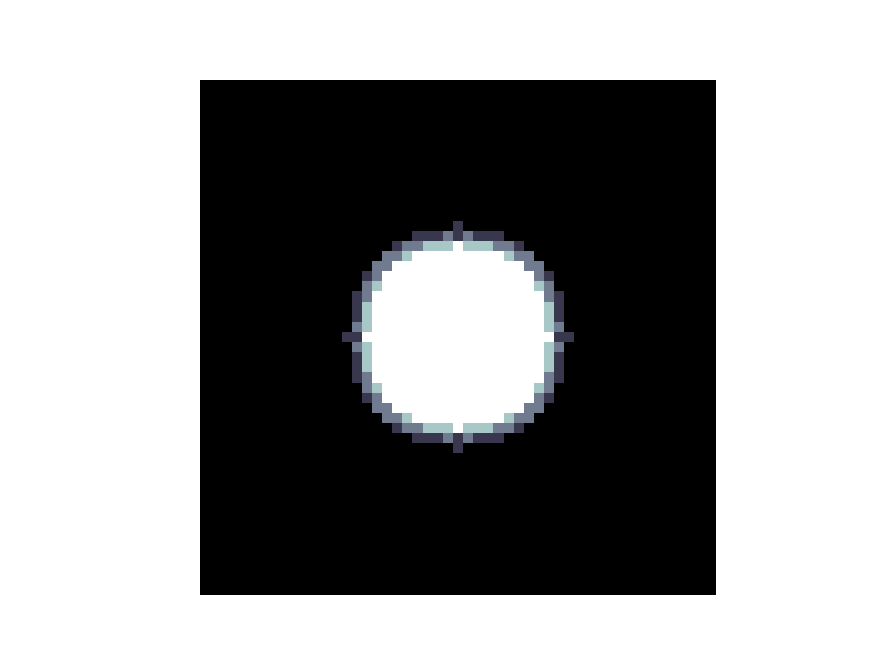

In [22]:
%matplotlib notebook

# define parameters of a circle in the grid
grid_size = 50    # our dimension size 'N' 
radius = 10      

# create array with zeros and a circle (values = 1) in the centre
y,x = np.ogrid[-(grid_size/2) : (grid_size/2)+1, -(grid_size/2): (grid_size/2)+1]
circle = x**2+y**2 <= radius**2
circle = circle.astype(float)

# set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
plt.axis('off')

# define the parameters of the animation
fps = 60
nSeconds = 5

# loop and append the output for each 'frame' to an empty array
frames = []     # array to contain all frames of animation
u_n = circle    # initialize starting array 
for i in range(fps*nSeconds):
    u_n = diffusion_iteration_const(u_n, S)
    frames.append(u_n)

# plot inital array
im = plt.imshow(circle, cmap='bone')

# animate figure using the matplotlib animation.FuncAnimation class
def animate_func(i):
    im.set_array(frames[i])
    return [im]
anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds*fps, interval = 1000/fps)
